In [3]:
# Setup
import numpy as np
import pandas as pd
import sys
import time
import scipy.sparse
import nci_linear_setup as ncls
import nci_polynomial_setup as ncps

import os

from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn

snipe rerun NN 1 layer 3 act

In [4]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'snipe1layer3act/'
save_path_graphs = 'snipe1layer3act/'

In [5]:
def fos_model_estimator_linear(y, z, A):
    
    from scipy.optimize import minimize
    import numpy as np
    import scipy

    n = len(z)

    # Compute normalized exposure E_i
    degrees = A.sum(axis=1)
    if scipy.sparse.issparse(degrees):
        degrees = np.array(degrees).flatten()
    elif isinstance(degrees, np.matrix):
        degrees = np.asarray(degrees).flatten()
    degrees[degrees == 0] = 1

    E = A.dot(z) / degrees

    def loss(params):
        tau, beta = params
        f_E = E * beta
        y_hat = tau * z + f_E
        return np.sum((y - y_hat)**2)

    tau0 = np.mean(y[z == 1]) - np.mean(y[z == 0])
    beta0 = 0.1
    x0 = [tau0, beta0]

    result = minimize(loss, x0, method='L-BFGS-B')
    if result.success:
        tau_hat, beta_hat = result.x
        f1 = np.sum(beta_hat)
        f0 = 0.0  
        return tau_hat + f1 - f0
    else:
        return np.nan



def fos_nn_estimator(y, z, A, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    torch.manual_seed(seed)

    n = len(z)

    # Compute normalized exposure E_i
    degrees = A.sum(axis=1)
    if scipy.sparse.issparse(degrees):
        degrees = np.array(degrees).flatten()
    elif isinstance(degrees, np.matrix):
        degrees = np.asarray(degrees).flatten()
    degrees[degrees == 0] = 1
    E = A.dot(z) / degrees  # shape: (n,)

    # Convert to torch tensors
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32).view(-1, 1)  # shape (n, 1)

    # Define 1-layer neural network with mixed activations
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super(FoSNet, self).__init__()
            self.linear1 = nn.Linear(input_dim, h1)   # linear only
            self.linear2 = nn.Linear(input_dim, h2)   # tanh
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)   # PReLU
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            o1 = self.linear1(E)              # linear
            o2 = self.act2(self.linear2(E))   # tanh
            o3 = self.act3(self.linear3(E))   # PReLU
            x = torch.cat([o1, o2, o3], dim=1)  # concat along feature
            return self.output(x).squeeze(-1)  # shape: (n,)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super(FoSFullModel, self).__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    # Initialize and train model
    model = FoSFullModel(input_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    # Compute plug-in ATE
    with torch.no_grad():
        ones_E = torch.ones_like(E)
        f1 = model.f_net(ones_E).mean().item()
        f0 = model.f_net(torch.zeros_like(E)).mean().item()
        tau_hat = model.tau.item()
        ate_hat = tau_hat + f1 - f0

    return ate_hat




def main(argv):
    from itertools import product
    import time

    n = 2000
    G = 8
    T = 250

    graphStr = "er"

    if graphStr == "sw":
        loadGraphs = True
    else:
        loadGraphs = False

    diag = 10
    degrees = [10]
    ps = [0.2]
    rs = [0.01, 0.1, 0.5, 1, 2, 4]
    true_models = ['snipe1', 'snipe2', 'linear', 'logit']

    f = open(save_path+'experiments_output.txt', 'w')
    start_time = time.time()

    results = []

    for p, r in product(ps, rs):
        for deg in degrees:
            for TM in true_models:
                print('True Model: {}'.format(TM))
                results.extend(run_experiment(G,T,n,p,r,deg,graphStr,TM,diag,loadGraphs))

    executionTime = (time.time() - start_time)
    print('Runtime in minutes: {}'.format(executionTime/60),file=f)  
    print('Runtime in minutes: {}\n'.format(executionTime/60))       
    df = pd.DataFrame.from_records(results)
    df.to_csv(save_path+graphStr+'-experiments_output.csv')


from tqdm import trange


def run_experiment(G,T,n,p,r,degree,graphStr,TM,diag=1, loadGraphs=False):
    
    offdiag = r*diag   # maximum norm of indirect effect

    results = []
    dict_base = {'p': p, 'ratio': r, 'n': n, 'TrueM': TM}

    sz = str(n) + '-'
    for g in range(G):
        graph_rep = str(g)
        dict_base.update({'Graph':sz+graph_rep})
        dict_base.update({'deg': degree})

        if loadGraphs:
            if graphStr == "sw":
                A = ncls.loadGraph(save_path_graphs+'SW'+str(n)+'.txt', n*n, True)
                n = n*n
                dict_base.update({'n':n})
                rand_wts = np.random.rand(n,3)
            else:
                # load weighted graph
                name = save_path_graphs + graphStr + sz + graph_rep
                A = scipy.sparse.load_npz(name+'-A.npz')
                rand_wts = np.load(name+'-wts.npy')
        else:
            if graphStr == "CON-prev":
                A = ncls.config_model_nx_prev(n,1000*n)
            if graphStr == "CON":
                A = ncls.config_model_nx(n)
            elif graphStr == "er":
                deg = degree
                A = ncls.erdos_renyi(n,deg/n)
            elif graphStr == "sw-ring":
                A = ncls.small_world(n,10,0.1)
            elif graphStr == "SBM":
                clusterSize = int(n/10)
                n = 10*clusterSize
                prob = 0.02 * np.random.beta(0.5, 0.5, (10, 10)) + np.diagflat(0.08 * np.random.beta(0.5, 0.5, (10, 1)))
                A = ncls.SBM(clusterSize, 10*prob/n)
            rand_wts = np.random.rand(n,3)

    
        alpha = rand_wts[:,0].flatten()
        C = ncls.simpleWeights(A, diag, offdiag, rand_wts[:,1].flatten(), rand_wts[:,2].flatten())
        # TODO: normalize here then absolute bias is fine
        
        if TM == "snipe1":
            fy = lambda z: ncls.linear_pom(C, alpha, z)

        elif TM == "snipe2":
            fy = ncps.ppom(2, C, alpha)

        elif TM == "linear":
            deg = np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + 1.0 * (A.dot(z) / deg)

        elif TM == "logit":
            def f_logit(E): return 1.0 / (1 + np.exp(-1.0 * E))
            E = A.dot(np.ones(n)) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + f_logit(A.dot(z) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1))

        elif TM == "exp":
            def f_exp(E): return 1.0 * (1 - np.exp(-1.0 * E))
            E = A.dot(np.ones(n)) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + f_exp(A.dot(z) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1))

        elif TM == "ls":
            E = A.dot(np.ones(n)) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + E

        elif TM == "dm":
            fy = lambda z: 1.0 * z

        else:
            raise ValueError(f"Unknown true_model: {TM}")


        # compute and print true TTE
        TTE = 1/n * np.sum((fy(np.ones(n)) - fy(np.zeros(n))))
        dict_base.update({'TTE':TTE})
        # print("Ground-Truth TTE: {}".format(TTE))


        ####### Estimate ########
        estimators = []
        
        estimators.append(lambda y,z,w: ncls.SNIPE_deg1(len(y), y, w))
        estimators.append(lambda y,z,w: ncps.SNIPE_beta(n,y,w))
        if TM == "snipe2":
            estimators.append(lambda y,z,w: ncps.poly_regression_prop(2, y, A, z))
            estimators.append(lambda y,z,w: ncps.poly_regression_num(2, y, A, z))
        else:
            estimators.append(lambda y,z,w: ncls.est_ols_gen(y,A,z))
            estimators.append(lambda y,z,w: ncls.est_ols_treated(y,A,z))
        
        estimators.append(lambda y,z,w: ncls.diff_in_means_naive(y,z))
        estimators.append(lambda y,z,w: ncls.diff_in_means_fraction(n,y,A,z,0.75))
        estimators.append(lambda y,z,w: fos_model_estimator_linear(y, z, A))
        estimators.append(lambda y,z,w: fos_nn_estimator(y, z, A))
        alg_names = ['SNIPE1', 'SNIPE2', 'LS-Prop', 'LS-Num', 'DM', 'DM($0.75$)', 'FoS-LINEAR', 'FoS-NN']



        N = [np.nonzero(A[[i],:])[1] for i in range(n)]  # neighbors
        dep_neighbors = A.dot(A.transpose())
        M = [np.nonzero(dep_neighbors[[i],:])[1] for i in range(n)] # dependencies

        for i in trange(T, desc=f"Graph {g} / n={n}"):
            dict_base.update({'rep':i, 'Rand': 'Bernoulli'})
            z = ncls.bernoulli(n,p)
            y = fy(z)
            zz = z/p - (1-z)/(1-p)
            w1 = A.dot(zz)            
            w2 = ncps.SNIPE_weights(n, p, A, z, 2)

            for ind in range(len(estimators)):
                if ind == 1:
                    est = estimators[ind](y,z,w2)
                    dict_base.update({'Estimator': alg_names[ind], 
                                  'TTE_Estimate': est,
                                  'Absolute_Bias': est-TTE,
                                  'Bias_squared': (est-TTE)**2,
                                  'Relative_Bias': (est-TTE)/TTE})
                    results.append(dict_base.copy())
                else:
                    est = estimators[ind](y,z,w1)
                    dict_base.update({'Estimator': alg_names[ind], 
                                  'TTE_Estimate': est,
                                  'Absolute_Bias': est-TTE,
                                  'Bias_squared': (est-TTE)**2,
                                  'Relative_Bias': (est-TTE)/TTE})
                    results.append(dict_base.copy())

    return results


if __name__ == "__main__":
    main(sys.argv[1:])

True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [04:49<00:00,  1.16s/it]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [17:22<00:00,  4.17s/it]  


True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [04:22<00:00,  1.05s/it]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [03:38<00:00,  1.15it/s]


True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [04:42<00:00,  1.13s/it]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [01:50<00:00,  2.27it/s]


True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [01:57<00:00,  2.13it/s]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [02:49<00:00,  1.47it/s]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [01:47<00:00,  2.33it/s]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [01:47<00:00,  2.34it/s]


True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [01:46<00:00,  2.34it/s]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [02:51<00:00,  1.46it/s]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [01:57<00:00,  2.12it/s]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [01:51<00:00,  2.25it/s]


True Model: snipe1


Graph 7 / n=2000: 100%|██████████| 250/250 [01:55<00:00,  2.17it/s]


True Model: snipe2


Graph 7 / n=2000: 100%|██████████| 250/250 [02:47<00:00,  1.49it/s]


True Model: linear


Graph 7 / n=2000: 100%|██████████| 250/250 [01:55<00:00,  2.16it/s]


True Model: logit


Graph 7 / n=2000: 100%|██████████| 250/250 [01:52<00:00,  2.22it/s]


Runtime in minutes: 866.298453271389



/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_49088/3593737858.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


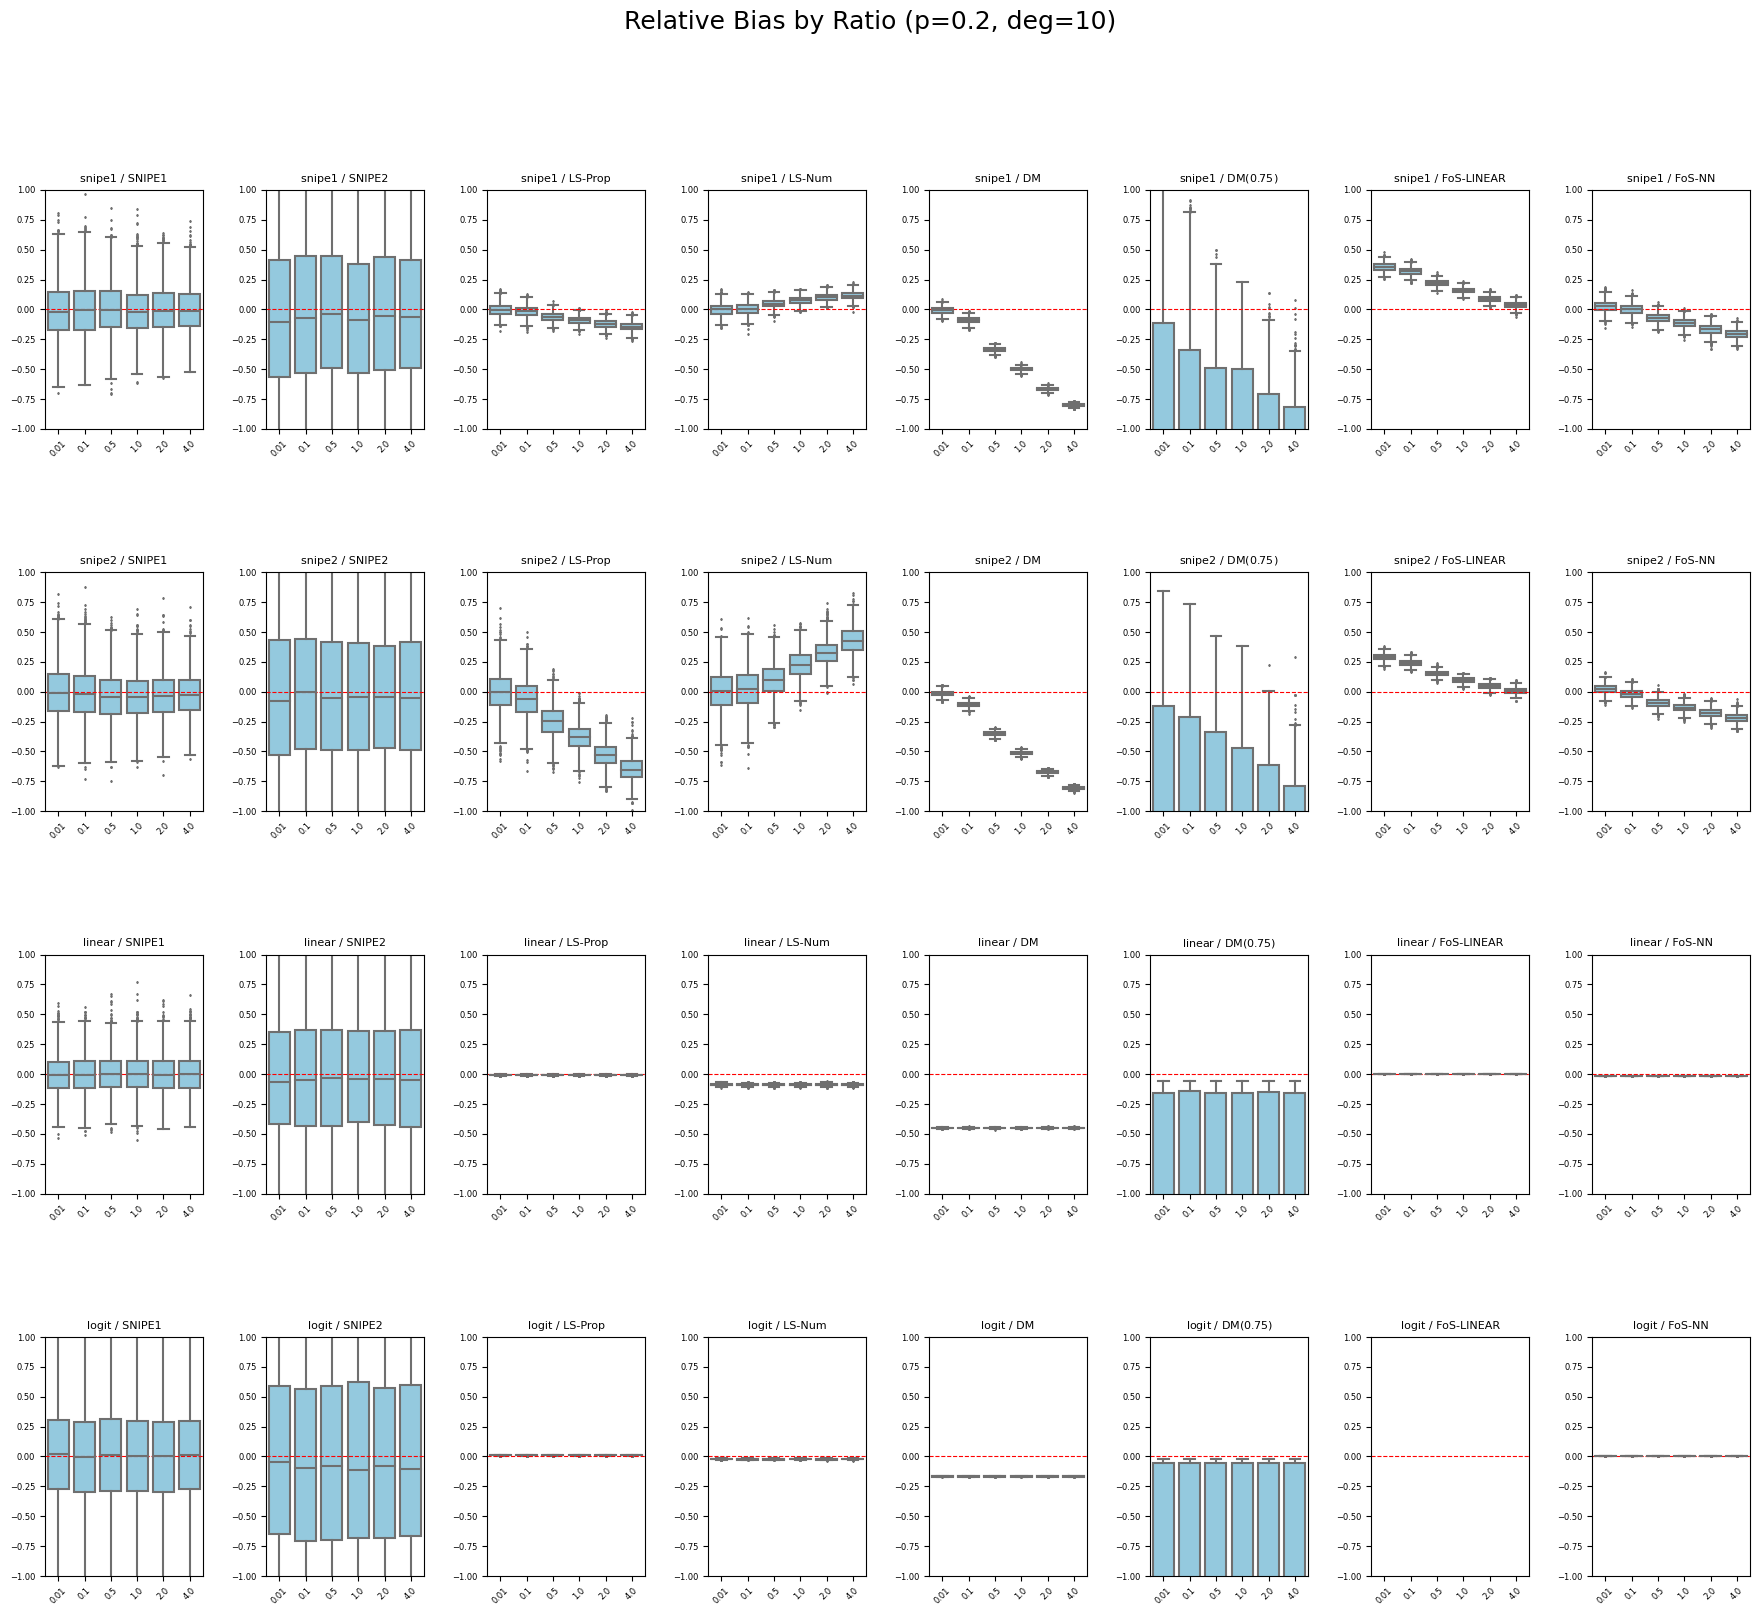

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.gridspec as gridspec

# 读取数据
df = pd.read_csv('snipe1layer3act/er-experiments_output.csv')

# 固定 p 和 deg，变化 r
ps = [0.2]
degrees = [10]  # 你可以修改为你想要的 degree 列表
estimators_order = ['SNIPE1', 'SNIPE2', 'LS-Prop', 'LS-Num', 'DM', 'DM($0.75$)', 'FoS-LINEAR', 'FoS-NN']
truemodels_order = ['snipe1', 'snipe2', 'linear', 'logit']

for p_val in ps:
    for deg_val in degrees:
        df_filtered = df[(df['p'] == p_val) & (df['deg'] == deg_val)].copy()
        if df_filtered.empty:
            print(f"Warning: No data for p={p_val}, deg={deg_val}")
            continue

        # 设置分类顺序
        df_filtered['Estimator'] = pd.Categorical(df_filtered['Estimator'], categories=estimators_order, ordered=True)
        df_filtered['TrueM'] = pd.Categorical(df_filtered['TrueM'], categories=truemodels_order, ordered=True)

        # 画图
        fig = plt.figure(figsize=(22, 18))
        gs = gridspec.GridSpec(len(truemodels_order), len(estimators_order), wspace=0.4, hspace=0.6)

        for i, tm in enumerate(truemodels_order):
            for j, est in enumerate(estimators_order):
                ax = fig.add_subplot(gs[i, j])
                data = df_filtered[(df_filtered['TrueM'] == tm) & (df_filtered['Estimator'] == est)]
                sns.boxplot(data=data, x='ratio', y='Relative_Bias', ax=ax, color='skyblue', fliersize=1)
                ax.axhline(0, color='red', linestyle='--', linewidth=0.8)
                ax.set_title(f'{tm} / {est}', fontsize=8)
                ax.set_xlabel('')
                ax.set_ylabel('')
                ax.tick_params(axis='x', labelrotation=45, labelsize=6)
                ax.tick_params(axis='y', labelsize=6)
                ax.set_ylim(-1, 1)

        plt.suptitle(f"Relative Bias by Ratio (p={p_val}, deg={deg_val})", fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

ER, NN 1 layer 3 act

In [7]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'ER_NN1lay3act/'
save_path_graphs = 'ER_NN1lay3act/'

In [8]:
def fos_model_estimator_linear(y, z, A):
    
    from scipy.optimize import minimize
    import numpy as np
    import scipy

    n = len(z)

    # Compute normalized exposure E_i
    degrees = A.sum(axis=1)
    if scipy.sparse.issparse(degrees):
        degrees = np.array(degrees).flatten()
    elif isinstance(degrees, np.matrix):
        degrees = np.asarray(degrees).flatten()
    degrees[degrees == 0] = 1

    E = A.dot(z) / degrees

    def loss(params):
        tau, beta = params
        f_E = E * beta
        y_hat = tau * z + f_E
        return np.sum((y - y_hat)**2)

    tau0 = np.mean(y[z == 1]) - np.mean(y[z == 0])
    beta0 = 0.1
    x0 = [tau0, beta0]

    result = minimize(loss, x0, method='L-BFGS-B')
    if result.success:
        tau_hat, beta_hat = result.x
        f1 = np.sum(beta_hat)
        f0 = 0.0  
        return tau_hat + f1 - f0
    else:
        return np.nan



def fos_nn_estimator(y, z, A, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    torch.manual_seed(seed)

    n = len(z)

    # === Compute normalized exposure E_i ===
    degrees = A.sum(axis=1)
    if scipy.sparse.issparse(degrees):
        degrees = np.array(degrees).flatten()
    elif isinstance(degrees, np.matrix):
        degrees = np.asarray(degrees).flatten()
    degrees[degrees == 0] = 1
    E = A.dot(z) / degrees  # shape: (n,)

    # === Convert to torch tensors ===
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32).view(-1, 1)  # shape: (n, 1)

    # === Define hybrid-activation neural net ===
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super(FoSNet, self).__init__()
            self.linear1 = nn.Linear(input_dim, h1)   # linear
            self.linear2 = nn.Linear(input_dim, h2)   # tanh
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)   # PReLU
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            o1 = self.linear1(E)
            o2 = self.act2(self.linear2(E))
            o3 = self.act3(self.linear3(E))
            x = torch.cat([o1, o2, o3], dim=1)
            return self.output(x).squeeze(-1)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super(FoSFullModel, self).__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    # === Fit model ===
    model = FoSFullModel(input_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    # === Plug-in population-level ATE ===
    with torch.no_grad():
        ones_E = torch.ones_like(E)
        f_1 = model.f_net(ones_E).mean().item()
        f_0 = model.f_net(torch.zeros_like(E)).mean().item()
        tau_hat = model.tau.item()
        ate_hat = tau_hat + f_1 - f_0

    return ate_hat





def main(argv):
    from itertools import product
    import time

    n = 4000
    G = 10
    T = 300

    graphStr = "er"

    if graphStr == "sw":
        loadGraphs = True
    else:
        loadGraphs = False

    diag = 10
    degrees = [10, 50, 100, 200, 500]
    ps = [0.5]
    rs = [0.5]
    true_models = ['snipe1', 'snipe2', 'exp', 'linear','dm']

    f = open(save_path+'experiments_output.txt', 'w')
    start_time = time.time()

    results = []

    for p, r in product(ps, rs):
        for deg in degrees:
            for TM in true_models:
                print('True Model: {}'.format(TM))
                results.extend(run_experiment(G,T,n,p,r,deg,graphStr,TM,diag,loadGraphs))

    executionTime = (time.time() - start_time)
    print('Runtime in minutes: {}'.format(executionTime/60),file=f)  
    print('Runtime in minutes: {}\n'.format(executionTime/60))       
    df = pd.DataFrame.from_records(results)
    df.to_csv(save_path+graphStr+'-experiments_output.csv')


from tqdm import trange


def run_experiment(G,T,n,p,r,degree,graphStr,TM,diag=1, loadGraphs=False):
    
    offdiag = r*diag   # maximum norm of indirect effect

    results = []
    dict_base = {'p': p, 'ratio': r, 'n': n, 'TrueM': TM}

    sz = str(n) + '-'
    for g in range(G):
        graph_rep = str(g)
        dict_base.update({'Graph':sz+graph_rep})
        dict_base.update({'deg': degree})

        if loadGraphs:
            if graphStr == "sw":
                A = ncls.loadGraph(save_path_graphs+'SW'+str(n)+'.txt', n*n, True)
                n = n*n
                dict_base.update({'n':n})
                rand_wts = np.random.rand(n,3)
            else:
                # load weighted graph
                name = save_path_graphs + graphStr + sz + graph_rep
                A = scipy.sparse.load_npz(name+'-A.npz')
                rand_wts = np.load(name+'-wts.npy')
        else:
            if graphStr == "CON-prev":
                A = ncls.config_model_nx_prev(n,1000*n)
            if graphStr == "CON":
                A = ncls.config_model_nx(n)
            elif graphStr == "er":
                deg = degree
                A = ncls.erdos_renyi(n,deg/n)
            elif graphStr == "sw-ring":
                A = ncls.small_world(n,10,0.1)
            elif graphStr == "SBM":
                clusterSize = int(n/10)
                n = 10*clusterSize
                prob = 0.02 * np.random.beta(0.5, 0.5, (10, 10)) + np.diagflat(0.08 * np.random.beta(0.5, 0.5, (10, 1)))
                A = ncls.SBM(clusterSize, 10*prob/n)
            rand_wts = np.random.rand(n,3)

    
        alpha = rand_wts[:,0].flatten()
        C = ncls.simpleWeights(A, diag, offdiag, rand_wts[:,1].flatten(), rand_wts[:,2].flatten())
        # TODO: normalize here then absolute bias is fine
        
        if TM == "snipe1":
            fy = lambda z: ncls.linear_pom(C, alpha, z)

        elif TM == "snipe2":
            fy = ncps.ppom(2, C, alpha)

        elif TM == "logit":
            def f_logit(E): return 1.0 / (1 + np.exp(-1.0 * E))
            E = A.dot(np.ones(n)) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + f_logit(A.dot(z) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1))

        elif TM == "exp":
            def f_exp(E): return 1.0 * (1 - np.exp(-1.0 * E))
            E = A.dot(np.ones(n)) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + f_exp(A.dot(z) / np.maximum(np.array(A.sum(axis=1)).flatten(), 1))

        elif TM == "linear":
            deg = np.maximum(np.array(A.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + 1.0 * (A.dot(z) / deg)  # includes self

        elif TM == "ls-prop":
            A_ls = A.copy()
            A_ls.setdiag(0)
            A_ls.eliminate_zeros()
            deg_ls = np.maximum(np.array(A_ls.sum(axis=1)).flatten(), 1)
            fy = lambda z: 1.0 * z + 0.5 * (A_ls.dot(z) / deg_ls)  # excludes self, normalized

        elif TM == "ls-num":
            A_ls = A.copy()
            A_ls.setdiag(0)
            A_ls.eliminate_zeros()
            fy = lambda z: 1.0 * z + 0.5 * A_ls.dot(z)  # excludes self, unnormalized


        elif TM == "dm":
            fy = lambda z: 1.0 * z


        else:
            raise ValueError(f"Unknown true_model: {TM}")


        # compute and print true TTE
        TTE = 1/n * np.sum((fy(np.ones(n)) - fy(np.zeros(n))))
        dict_base.update({'TTE':TTE})
        # print("Ground-Truth TTE: {}".format(TTE))


        ####### Estimate ########
        estimators = []
        
        estimators.append(lambda y,z,w: ncls.SNIPE_deg1(len(y), y, w))
        estimators.append(lambda y,z,w: ncps.SNIPE_beta(n,y,w))

        if TM == "snipe2":
            estimators.append(lambda y,z,w: ncps.poly_regression_prop(2, y, A, z))
            estimators.append(lambda y,z,w: ncps.poly_regression_num(2, y, A, z))
        else:
            estimators.append(lambda y,z,w: ncls.est_ols_gen(y,A,z))
            estimators.append(lambda y,z,w: ncls.est_ols_treated(y,A,z))
        
        estimators.append(lambda y,z,w: ncls.diff_in_means_naive(y,z))
        estimators.append(lambda y,z,w: ncls.diff_in_means_fraction(n,y,A,z,0.75))

        estimators.append(lambda y,z,w: fos_model_estimator_linear(y, z, A))
        estimators.append(lambda y,z,w: fos_nn_estimator(y, z, A))
        alg_names = ['SNIPE1', 'SNIPE2', 'LS-Prop', 'LS-Num', 'DM', 'DM($0.75$)', 'FoS-LINEAR', 'FoS-NN']



        N = [np.nonzero(A[[i],:])[1] for i in range(n)]  # neighbors
        dep_neighbors = A.dot(A.transpose())
        M = [np.nonzero(dep_neighbors[[i],:])[1] for i in range(n)] # dependencies

        for i in trange(T, desc=f"Graph {g} / n={n}"):
            dict_base.update({'rep':i, 'Rand': 'Bernoulli'})
            z = ncls.bernoulli(n,p)
            y = fy(z)
            zz = z/p - (1-z)/(1-p)
            w1 = A.dot(zz)            
            w2 = ncps.SNIPE_weights(n, p, A, z, 2)

            for ind in range(len(estimators)):
                if ind == 1:
                    est = estimators[ind](y,z,w2)
                    dict_base.update({'Estimator': alg_names[ind], 
                                  'TTE_Estimate': est,
                                  'Absolute_Bias': est-TTE,
                                  'Bias_squared': (est-TTE)**2,
                                  'Relative_Bias': (est-TTE)/TTE})
                    results.append(dict_base.copy())
                else:
                    est = estimators[ind](y,z,w1)
                    dict_base.update({'Estimator': alg_names[ind], 
                                  'TTE_Estimate': est,
                                  'Absolute_Bias': est-TTE,
                                  'Bias_squared': (est-TTE)**2,
                                  'Relative_Bias': (est-TTE)/TTE})
                    results.append(dict_base.copy())

    return results


if __name__ == "__main__":
    main(sys.argv[1:])


True Model: snipe1


Graph 9 / n=4000: 100%|██████████| 300/300 [02:58<00:00,  1.68it/s]


True Model: snipe2


Graph 9 / n=4000: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


True Model: exp


Graph 9 / n=4000: 100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


True Model: linear


Graph 9 / n=4000: 100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


True Model: dm


Graph 9 / n=4000: 100%|██████████| 300/300 [03:03<00:00,  1.64it/s]


True Model: snipe1


Graph 9 / n=4000: 100%|██████████| 300/300 [03:05<00:00,  1.62it/s]


True Model: snipe2


Graph 9 / n=4000: 100%|██████████| 300/300 [04:19<00:00,  1.16it/s]


True Model: exp


Graph 9 / n=4000: 100%|██████████| 300/300 [02:52<00:00,  1.74it/s]


True Model: linear


Graph 9 / n=4000: 100%|██████████| 300/300 [02:45<00:00,  1.81it/s]


True Model: dm


Graph 9 / n=4000: 100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


True Model: snipe1


Graph 9 / n=4000: 100%|██████████| 300/300 [03:01<00:00,  1.66it/s]


True Model: snipe2


Graph 9 / n=4000: 100%|██████████| 300/300 [04:08<00:00,  1.21it/s]


True Model: exp


Graph 9 / n=4000: 100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


True Model: linear


Graph 9 / n=4000: 100%|██████████| 300/300 [02:55<00:00,  1.71it/s]


True Model: dm


Graph 9 / n=4000: 100%|██████████| 300/300 [03:01<00:00,  1.66it/s]


True Model: snipe1


Graph 9 / n=4000: 100%|██████████| 300/300 [03:15<00:00,  1.54it/s]


True Model: snipe2


Graph 9 / n=4000: 100%|██████████| 300/300 [04:16<00:00,  1.17it/s]


True Model: exp


Graph 9 / n=4000: 100%|██████████| 300/300 [03:07<00:00,  1.60it/s]


True Model: linear


Graph 9 / n=4000: 100%|██████████| 300/300 [02:58<00:00,  1.68it/s]


True Model: dm


Graph 9 / n=4000: 100%|██████████| 300/300 [02:48<00:00,  1.78it/s]


True Model: snipe1


Graph 9 / n=4000: 100%|██████████| 300/300 [02:57<00:00,  1.69it/s]


True Model: snipe2


Graph 9 / n=4000: 100%|██████████| 300/300 [04:16<00:00,  1.17it/s]


True Model: exp


Graph 9 / n=4000: 100%|██████████| 300/300 [02:57<00:00,  1.69it/s]


True Model: linear


Graph 9 / n=4000: 100%|██████████| 300/300 [03:03<00:00,  1.64it/s]


True Model: dm


Graph 9 / n=4000: 100%|██████████| 300/300 [03:11<00:00,  1.57it/s]


Runtime in minutes: 919.6796242157618



/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_49088/1868130148.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


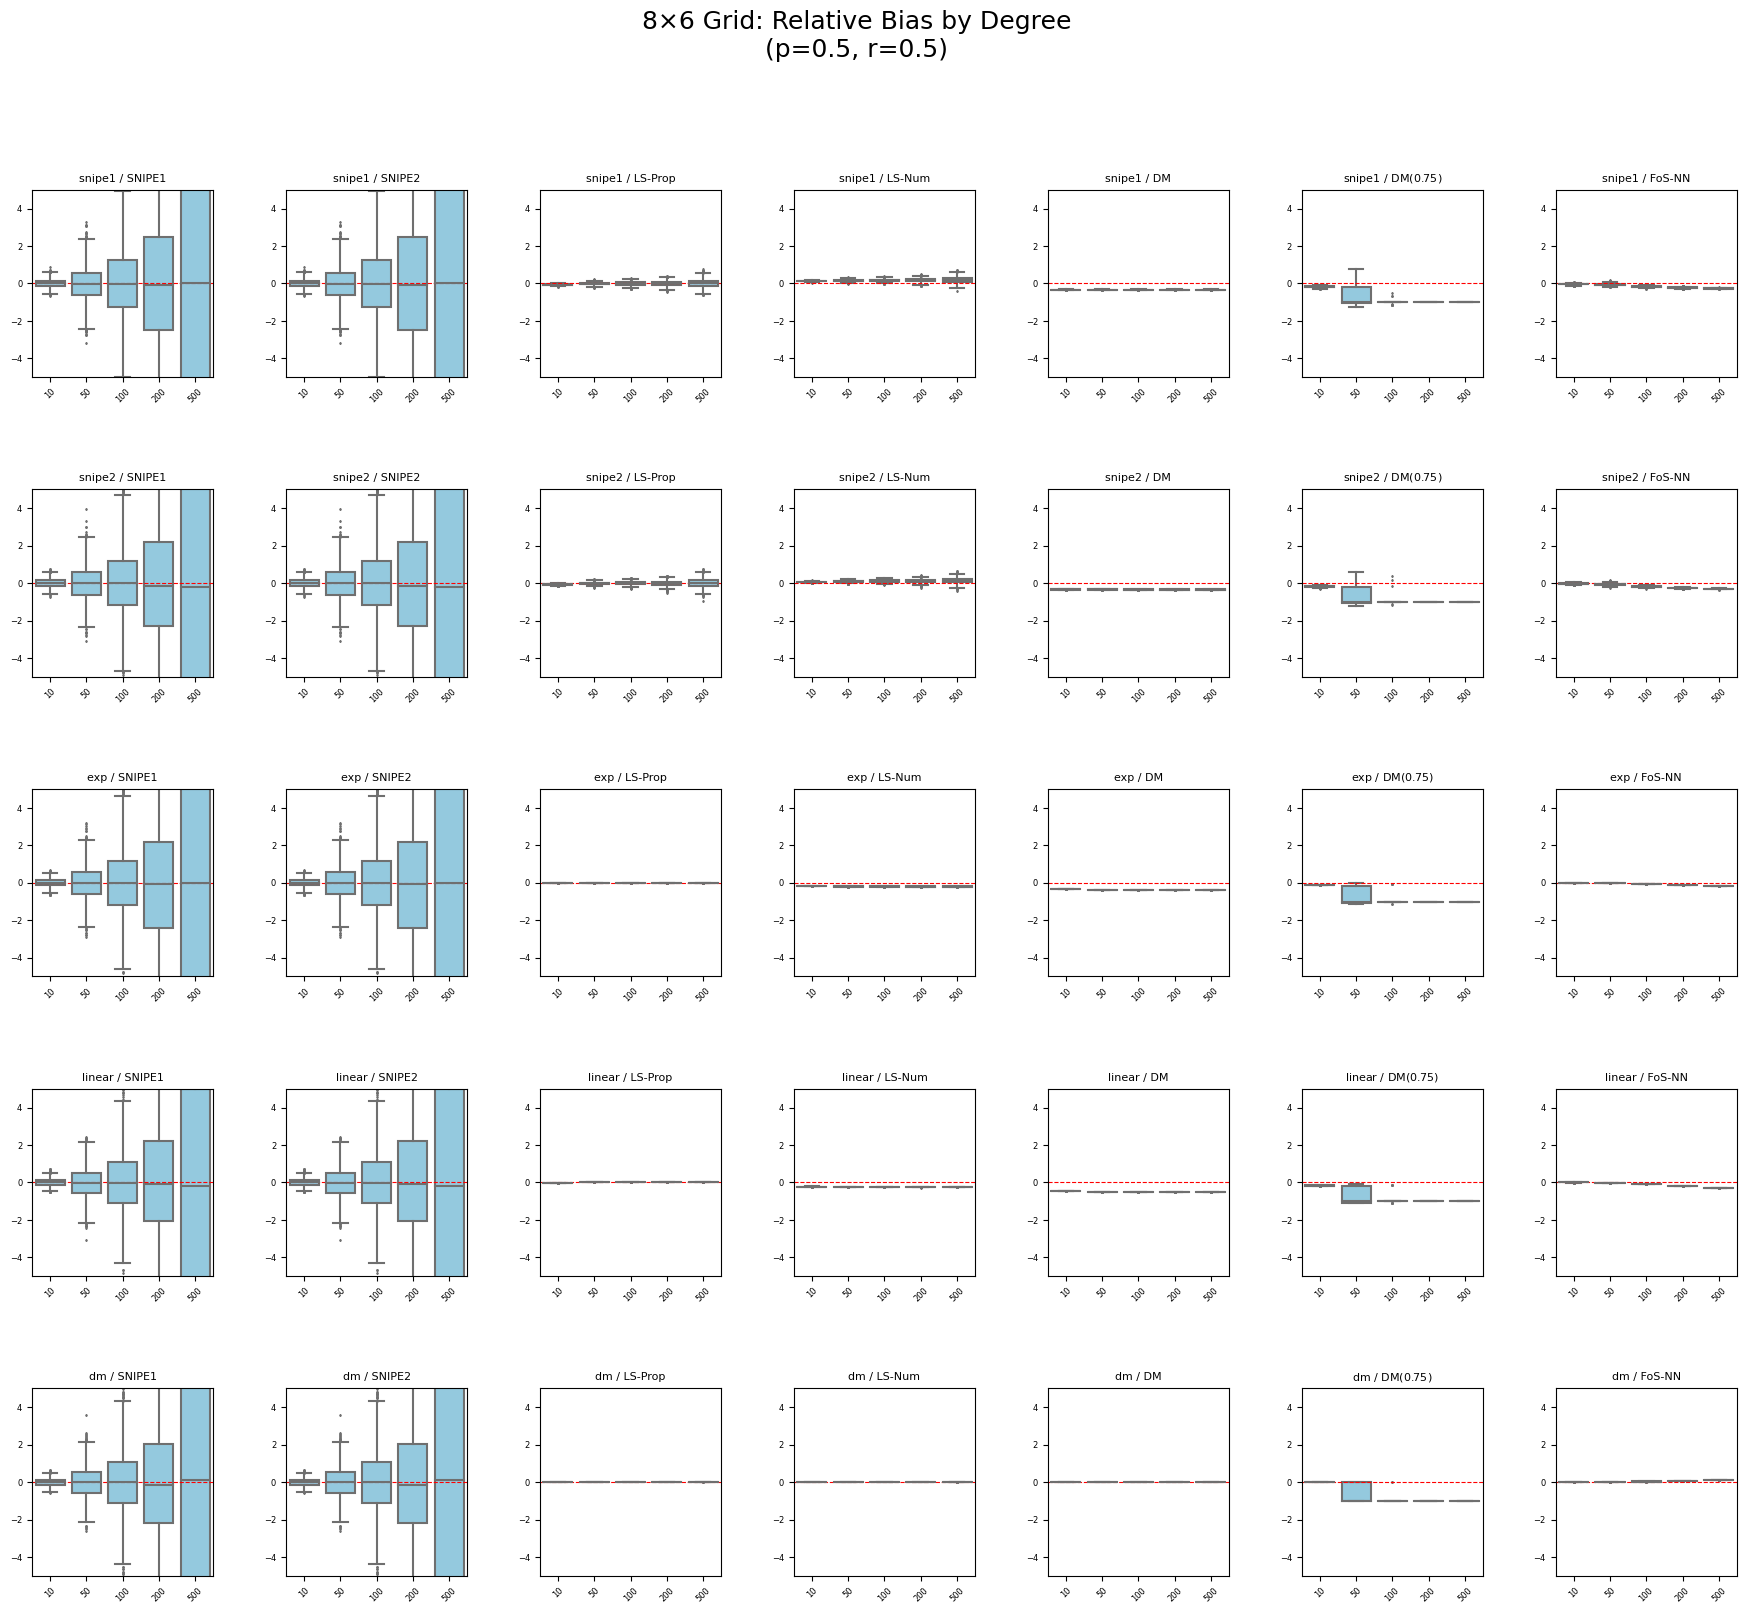

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 读取结果数据
df = pd.read_csv('ER_NN1lay3act/er-experiments_output.csv')


# 创建保存目录
os.makedirs('figures_boxplots', exist_ok=True)

# Prepare data: filter again just in case and compute relative bias grouped
df_filtered = df[(df['p'] == 0.5) & (df['ratio'] == 0.5)].copy()

# Ensure proper categorical ordering
estimators_order = ['SNIPE1', 'SNIPE2', 'LS-Prop', 'LS-Num', 'DM', 'DM($0.75$)', 'FoS-NN']
truemodels_order = ['snipe1', 'snipe2', 'exp', 'linear','dm']
df_filtered['Estimator'] = pd.Categorical(df_filtered['Estimator'], categories=estimators_order, ordered=True)
df_filtered['TrueM'] = pd.Categorical(df_filtered['TrueM'], categories=truemodels_order, ordered=True)

# Set up 6 rows (TrueM) × 8 columns (Estimator)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(22, 18))
gs = gridspec.GridSpec(len(truemodels_order), len(estimators_order), wspace=0.4, hspace=0.6)

for i, tm in enumerate(truemodels_order):
    for j, est in enumerate(estimators_order):
        ax = fig.add_subplot(gs[i, j])
        data = df_filtered[(df_filtered['TrueM'] == tm) & (df_filtered['Estimator'] == est)]
        sns.boxplot(data=data, x='deg', y='Relative_Bias', ax=ax, color='skyblue', fliersize=1)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8)
        ax.set_title(f'{tm} / {est}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelrotation=45, labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.set_ylim(-5, 5)

# Global layout
plt.suptitle("8×6 Grid: Relative Bias by Degree\n(p=0.5, r=0.5)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

multi E, negative effect but positive beta, NN, graph2 ver2 test 1 NN 3 act

In [10]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'test1NN3act/'
save_path_graphs = 'test1NN3act/'

In [11]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import nci_linear_setup as ncls
import nci_polynomial_setup as ncps
import os
import torch
import torch.nn as nn

# === Parameters ===
n = 4000
p = 0.3
tau, Lambda, alpha = 2.0, -2.0, 1.0
k_list = [10, 50, 100, 500, 800]
sigma2 = 0.1
T = 200 
d = 5
beta_vec = np.array([-2, 3, -4, 5, -6])

# === Functions ===
def generate_covariates(n, d):
    X = np.random.randn(n, d)
    return (X - X.mean(axis=0)) / X.std(axis=0)


def compute_multi_kernel(X, alpha):
    d = X.shape[1]
    K_list = []
    for k in range(d):
        x_k = X[:, k][:, np.newaxis]
        dist2 = squareform(pdist(x_k)) ** 2
        K = np.exp(-alpha * dist2)
        np.fill_diagonal(K, 0)
        K_list.append(K)
    return np.array(K_list)  # shape (d, n, n)

def construct_adjacency_from_kernel(K, k):
    n = K.shape[0]
    A = np.zeros((n, n))
    for i in range(n):
        neighbors = np.argsort(-K[i, :])[:k]
        A[i, neighbors] = 1
    np.fill_diagonal(A, 1)
    return scipy.sparse.csr_matrix(A)

def generate_treatment(n, p):
    return np.random.binomial(1, p, size=n)

def compute_vector_exposure(K_list, z):
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)
    return E  # shape (n, d)

def generate_outcomes(z, A, K_list, true_model):
    E = compute_vector_exposure(K_list, z)
    W = A.dot(z / p - (1 - z) / (1 - p))
    eps = np.random.normal(0, np.sqrt(sigma2), size=z.shape)
    # shared setup
    rand_wts = np.random.rand(n, 3)
    rand_weight_alpha = rand_wts[:, 0].flatten()
    rand_diag = rand_wts[:, 1].flatten()
    rand_offdiag = rand_wts[:, 2].flatten()
    diag = tau
    offdiag = Lambda / (1 + np.exp(-np.sum(beta_vec)))
    C = ncls.simpleWeights(A, diag, offdiag, rand_diag, rand_offdiag)

    if true_model == 'linear':
        f = lambda e: np.dot(beta_vec, e)
        f_vec = np.array([f(e) for e in E])
        y = tau * z + f_vec + eps
        f1 = np.sum(beta_vec)
        f0 = 0.0
        true_ate = tau + f1 - f0

    elif true_model == 'logit':
        f = lambda e: Lambda / (1 + np.exp(-np.dot(beta_vec, e)))
        f_vec = np.array([f(e) for e in E])
        y = tau * z + f_vec + eps
        f1 = Lambda / (1 + np.exp(-np.sum(beta_vec)))
        f0 = Lambda / (1 + np.exp(0))
        true_ate = tau + f1 - f0


    else:
        raise ValueError("Unknown true_model")

    return y, E, W, true_ate


def fos_model_estimator_linear(y, z, K_list):
    E = compute_vector_exposure(K_list, z)
    d = E.shape[1]

    def loss(params):
        tau = params[0]
        beta = params[1:]
        f_E = E @ beta
        return np.sum((y - tau * z - f_E) ** 2)

    x0 = np.concatenate(([1.0], np.ones(d)))
    res = minimize(loss, x0=x0, method='L-BFGS-B')
    tau_hat, *beta_hat = res.x

    f1 = np.sum(beta_hat)     # when E = [1,...,1]
    f0 = 0.0                  # when E = [0,...,0]
    return tau_hat + f1 - f0


def fos_nn_estimator(y, z, K_list, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    """
    Neural network FoS estimator with one hidden layer, containing:
    - h1 units with Linear-only
    - h2 units with Tanh
    - h3 units with PReLU
    Total hidden units = h1 + h2 + h3
    """
    torch.manual_seed(seed)

    # === Compute vector exposure E from K_list ===
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)

    # === Convert to torch tensors ===
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32)

    # === Define neural network ===
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super(FoSNet, self).__init__()
            self.linear1 = nn.Linear(input_dim, h1)  # linear only
            self.linear2 = nn.Linear(input_dim, h2)  # + tanh
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)  # + prelu
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            out1 = self.linear1(E)                      # (n, h1)
            out2 = self.act2(self.linear2(E))           # (n, h2)
            out3 = self.act3(self.linear3(E))           # (n, h3)
            mixed = torch.cat([out1, out2, out3], dim=1)  # (n, h1+h2+h3)
            return self.output(mixed).squeeze(-1)         # (n,)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super(FoSFullModel, self).__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    # === Fit model ===
    model = FoSFullModel(input_dim=E.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    # === Plug-in ATE
    with torch.no_grad():
        ones_E = torch.ones_like(E)
        f_1 = model.f_net(ones_E).mean().item()
        f_0 = model.f_net(torch.zeros_like(E)).mean().item()
        tau_hat = model.tau.item()
        ate_hat = tau_hat + f_1 - f_0

    return ate_hat


from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph

def graph_laplacian_covariates_rotated(A, d, m=20, seed=42):
    
    n = A.shape[0]
    L = csgraph.laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=m + 1, which='SM')  
    spectral_feats = vecs[:, 1:]  

    # 随机旋转
    rng = np.random.default_rng(seed)
    R = rng.normal(size=(m, d))
    X_rot = spectral_feats @ R  # shape = (n, d)

    # 标准化
    X_rot = (X_rot - X_rot.mean(axis=0)) / X_rot.std(axis=0)
    return X_rot



def generate_symmetric_uniform_graph(n=200, mean_degree=10, seed=None):
    """
    Generate a symmetric undirected graph with degrees sampled from Uniform[0, 2*mean_degree].
    Returns:
        A (csr_matrix): Symmetric adjacency matrix (with self-loops)
        degrees (ndarray): Degree of each node
    """
    if seed is not None:
        np.random.seed(seed)

    max_deg = 2 * mean_degree
    sampled_degrees = np.random.randint(0, max_deg + 1, size=n)
    A = np.zeros((n, n), dtype=int)
    degree_remain = sampled_degrees.copy()

    for i in range(n):
        if degree_remain[i] <= 0:
            continue
        candidates = np.where((degree_remain > 0) & (np.arange(n) != i) & (A[i] == 0))[0]
        np.random.shuffle(candidates)
        num_to_connect = min(degree_remain[i], len(candidates))
        chosen = candidates[:num_to_connect]
        for j in chosen:
            if degree_remain[i] > 0 and degree_remain[j] > 0:
                A[i, j] = 1
                A[j, i] = 1
                degree_remain[i] -= 1
                degree_remain[j] -= 1

    np.fill_diagonal(A, 1)
    A_sparse = scipy.sparse.csr_matrix(A)
    degrees = A_sparse.sum(axis=1).A1
    return A_sparse, degrees



# === Simulation ===
os.makedirs(save_path, exist_ok=True)
all_records = []

for true_model in ['linear', 'logit']:
    print(f"Running true_model = {true_model}")
    for t in range(T):

        for k in k_list:
            A, degrees = generate_symmetric_uniform_graph(n=n, mean_degree=k)
            X = graph_laplacian_covariates_rotated(A, d)
            K = compute_multi_kernel(X, alpha)
            z = generate_treatment(n, p)
            y, E, W, true_ate = generate_outcomes(z, A, K, true_model)

            # SNIPE1
            w = A.dot(z / p - (1 - z) / (1 - p))
            est = ncls.SNIPE_deg1(len(y), y, w)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'SNIPE1', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # SNIPE2
            w2 = ncps.SNIPE_weights(n, p, A, z, 2)
            est = ncps.SNIPE_beta(n, y, w2)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'SNIPE2', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # LS-Num
            est = ncls.est_ols_gen(y, A, z)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'LS-Num', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # LS-Prop
            est = ncls.est_ols_treated(y, A, z)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'LS-Prop', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # DM
            est = ncls.diff_in_means_naive(y, z)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'DM', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # DM(0.75)
            est = ncls.diff_in_means_fraction(n, y, A, z, 0.75)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'DM(0.75)', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # FoS (linear)
            est = fos_model_estimator_linear(y, z, K)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'FoS (linear)', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})

            # FoS (NN)
            est = fos_nn_estimator(y, z, K)
            all_records.append({'rep': t, 'k': k, 'true_model': true_model, 'estimator': 'FoS (NN)', 'est': est, 'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate})


# === Save results ===
df = pd.DataFrame(all_records)
df.to_csv(os.path.join(save_path, "simulation_results_all_models.csv"), index=False)

Running true_model = linear
Running true_model = logit


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_49088/3076080226.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


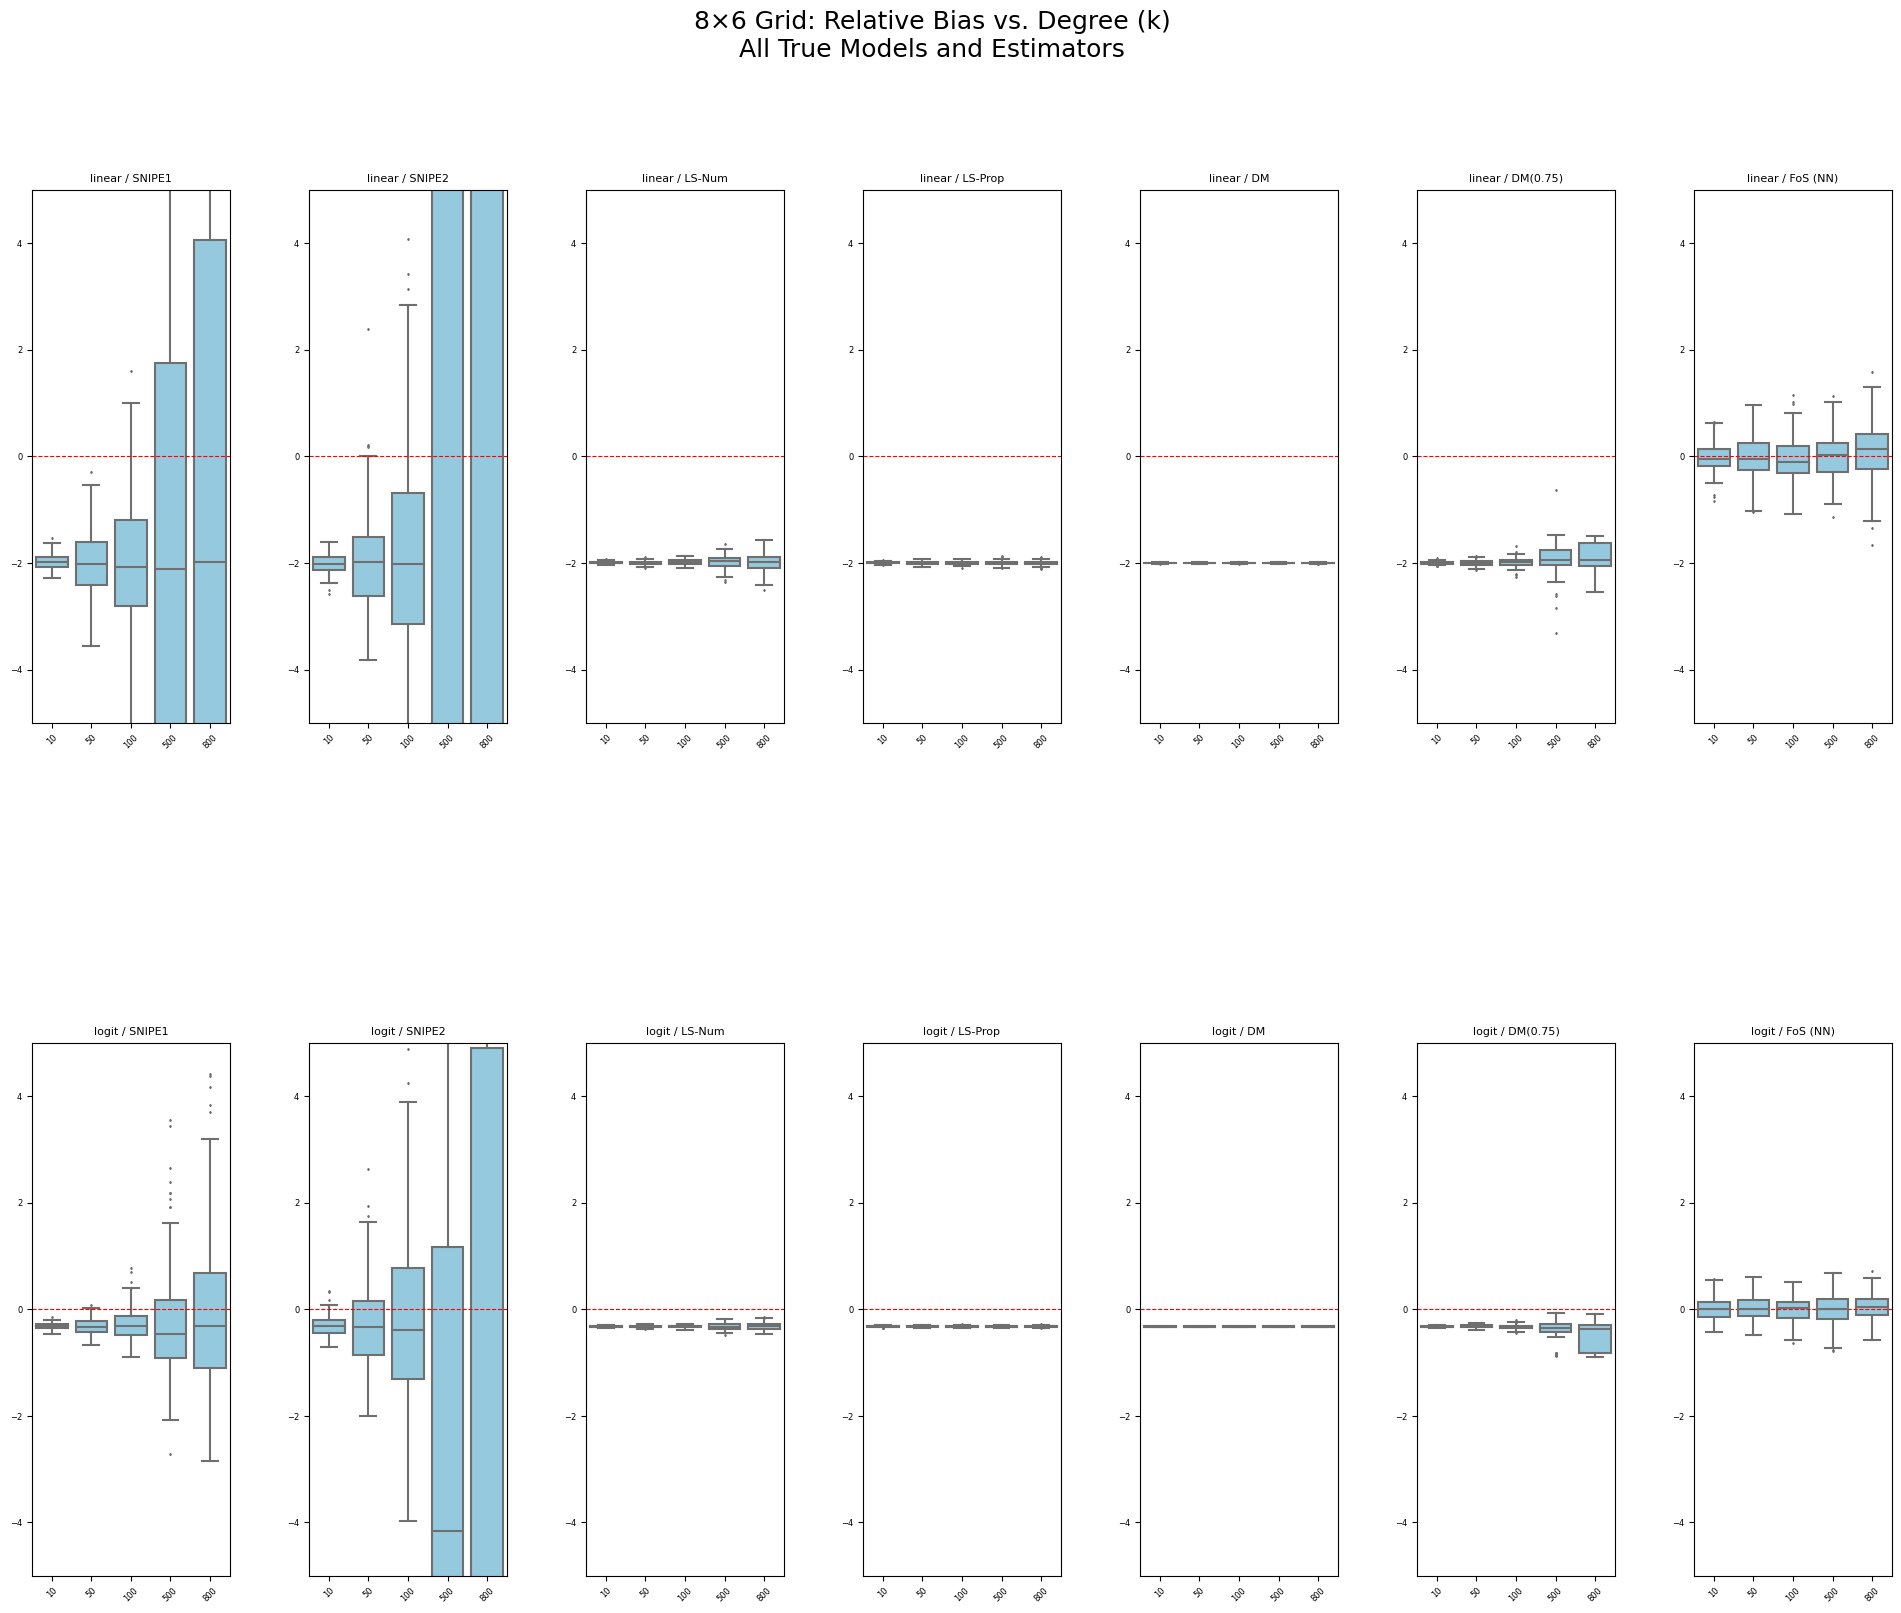

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.gridspec as gridspec

# === Load simulation result ===
df = pd.read_csv(os.path.join(save_path, "simulation_results_all_models.csv"))

# === Create save folder ===
os.makedirs('figures_boxplots2', exist_ok=True)

# === Prepare data ===
estimators_order = ['SNIPE1', 'SNIPE2', 'LS-Num', 'LS-Prop', 'DM', 'DM(0.75)', 'FoS (NN)']
truemodels_order = ['linear', 'logit']
    
df['estimator'] = pd.Categorical(df['estimator'], categories=estimators_order, ordered=True)
df['true_model'] = pd.Categorical(df['true_model'], categories=truemodels_order, ordered=True)

# === Plot ===
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(len(truemodels_order), len(estimators_order), wspace=0.4, hspace=0.6)

for i, tm in enumerate(truemodels_order):
    for j, est in enumerate(estimators_order):
        ax = fig.add_subplot(gs[i, j])
        subdata = df[(df['true_model'] == tm) & (df['estimator'] == est)]
        sns.boxplot(data=subdata, x='k', y='rel_bias', ax=ax, color='skyblue', fliersize=1)
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8)
        ax.set_title(f'{tm} / {est}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', labelrotation=45, labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        ax.set_ylim(-5, 5)


plt.suptitle("8×6 Grid: Relative Bias vs. Degree (k)\nAll True Models and Estimators", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figures_boxplots/relative_bias_grid.png", dpi=300)
plt.show()

Dose start 0, NN 1 layer 3 act

In [13]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'doseS01layer3act/'
save_path_graphs = 'doseS01layer3act/'

In [14]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import nci_linear_setup as ncls
import nci_polynomial_setup as ncps
import os
import torch
import torch.nn as nn

# === Parameters ===
n = 4000
tau, Lambda, alpha = 2.0, -2.0, 1.0
k_list = [10]
sigma2 = 0.1
T = 200 
d = 5
beta_vec = np.array([1, 2, 2, 1, 3])
dose_list = [0.2, 0.4, 0.6, 0.8]

# === Functions ===
def generate_covariates(n, d):
    X = np.random.randn(n, d)
    return (X - X.mean(axis=0)) / X.std(axis=0)

def compute_kernel(X, alpha):
    dist2 = squareform(pdist(X)) ** 2
    K = np.exp(-alpha * dist2)
    np.fill_diagonal(K, 0)
    return K

def compute_multi_kernel(X, alpha):
    d = X.shape[1]
    K_list = []
    for k in range(d):
        x_k = X[:, k][:, np.newaxis]
        dist2 = squareform(pdist(x_k)) ** 2
        K = np.exp(-alpha * dist2)
        np.fill_diagonal(K, 0)
        K_list.append(K)
    return np.array(K_list)  # shape (d, n, n)

def construct_adjacency_from_kernel(K, k):
    n = K.shape[0]
    A = np.zeros((n, n))
    for i in range(n):
        neighbors = np.argsort(-K[i, :])[:k]
        A[i, neighbors] = 1
    np.fill_diagonal(A, 1)
    return scipy.sparse.csr_matrix(A)


def compute_vector_exposure(K_list, z):
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)
    return E  # shape (n, d)

def generate_outcomes(z, A, K_list, true_model, D_fixed):
    E = compute_vector_exposure(K_list, z)
    eps = np.random.normal(0, np.sqrt(sigma2), size=z.shape)

    if true_model == 'linear':
        f = lambda e: np.dot(beta_vec, e)
        f_vec = np.array([f(e) for e in E])
        y = tau * z + f_vec + eps
        f0 = 0.0
        true_ate = tau * D_fixed + np.mean(f_vec) - f0

    elif true_model == 'logit':
        f = lambda e: Lambda / (1 + np.exp(-np.dot(beta_vec, e)))
        f_vec = np.array([f(e) for e in E])
        y = tau * z + f_vec + eps
        f0 = Lambda / (1 + np.exp(0))
        true_ate = tau * D_fixed + np.mean(f_vec) - f0

    else:
        raise ValueError("Unknown true_model")

    return y, E, A.dot(z), true_ate



def fos_model_estimator_linear(y, z, K_list):
    E = compute_vector_exposure(K_list, z)
    d = E.shape[1]

    def loss(params):
        tau = params[0]
        beta = params[1:]
        f_E = E @ beta
        return np.sum((y - tau * z - f_E) ** 2)

    x0 = np.concatenate(([1.0], np.ones(d)))
    res = minimize(loss, x0=x0, method='L-BFGS-B')
    tau_hat, *beta_hat = res.x

    D = np.mean(z)
    f_E = E @ np.array(beta_hat)
    f0 = 0.0  # linear case

    ate_dose = tau_hat * D + np.mean(f_E) - f0
    return ate_dose



def fos_nn_estimator(y, z, K_list, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    torch.manual_seed(seed)

    # === Compute vector exposure E from K_list ===
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)

    # === Convert to torch tensors ===
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32)

    # === Define hybrid-activation neural network ===
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super(FoSNet, self).__init__()
            self.linear1 = nn.Linear(input_dim, h1)   # linear
            self.linear2 = nn.Linear(input_dim, h2)   # tanh
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)   # prelu
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            o1 = self.linear1(E)
            o2 = self.act2(self.linear2(E))
            o3 = self.act3(self.linear3(E))
            x = torch.cat([o1, o2, o3], dim=1)
            return self.output(x).squeeze(-1)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super(FoSFullModel, self).__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))  # scalar τ
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    # === Fit model ===
    model = FoSFullModel(input_dim=E.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    # === Plug-in population-level ATE ===
    with torch.no_grad():
        D = z.mean().item()
        f_E = model.f_net(E).mean().item()
        f0 = model.f_net(torch.zeros_like(E)).mean().item()
        tau_hat = model.tau.item()
        ate_dose = tau_hat * D + f_E - f0

    return ate_dose



def est_ols_gen_dose(y, A, z):
    n = A.shape[0]
    X = np.ones((n, 3))
    X[:,1] = z
    X[:,2] = (A.dot(z) - z) / (np.array(A.sum(axis=1)).flatten() - 1 + 1e-10)
    
    v = np.linalg.lstsq(X, y, rcond=None)[0]
    D = np.mean(z)
    exposure_mean = np.mean(X[:,2])
    
    return v[1] * D + v[2] * exposure_mean


def est_ols_treated_dose(y, A, z):
    n = A.shape[0]
    X = np.ones((n, 3))
    X[:,1] = z
    X[:,2] = A.dot(z) - z
    
    v = np.linalg.lstsq(X, y, rcond=None)[0]
    D = np.mean(z)
    exposure_mean = np.mean(X[:,2])
    
    return v[1] * D + v[2] * exposure_mean



def generate_fixed_treatment(n, D, seed=None):
    """
    Generate a binary treatment vector with fixed treatment proportion D.
    """
    if seed is not None:
        np.random.seed(seed)
    num_treated = int(D * n)
    z = np.zeros(n)
    z[:num_treated] = 1
    np.random.shuffle(z)
    return z





# === Simulation ===
os.makedirs(save_path, exist_ok=True)
all_records = []

for true_model in ['linear', 'logit']:
    print(f"Running true_model = {true_model}")
    for D_fixed in dose_list:
        for t in range(T):
            X = generate_covariates(n,d)
            K = compute_multi_kernel(X, alpha)
            K2 = compute_kernel(X, alpha)
            z = generate_fixed_treatment(n, D_fixed)

            for k in k_list:
                A = construct_adjacency_from_kernel(K2, k)
                y, E, W, true_ate = generate_outcomes(z, A, K, true_model, D_fixed)

                # LS-Num
                est = est_ols_gen_dose(y, A, z)  # 若你采用新版本函数
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Num', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # LS-Prop
                est = est_ols_treated_dose(y, A, z)
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Prop', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # FoS (linear)
                est = fos_model_estimator_linear(y, z, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (linear)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed  # 添加 dose
                })

                # FoS (NN)
                est = fos_nn_estimator(y, z, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (NN)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed
                })


# === Save results ===
df = pd.DataFrame(all_records)
df.to_csv(os.path.join(save_path, "simulation_results_all_models.csv"), index=False)

Running true_model = linear
Running true_model = logit


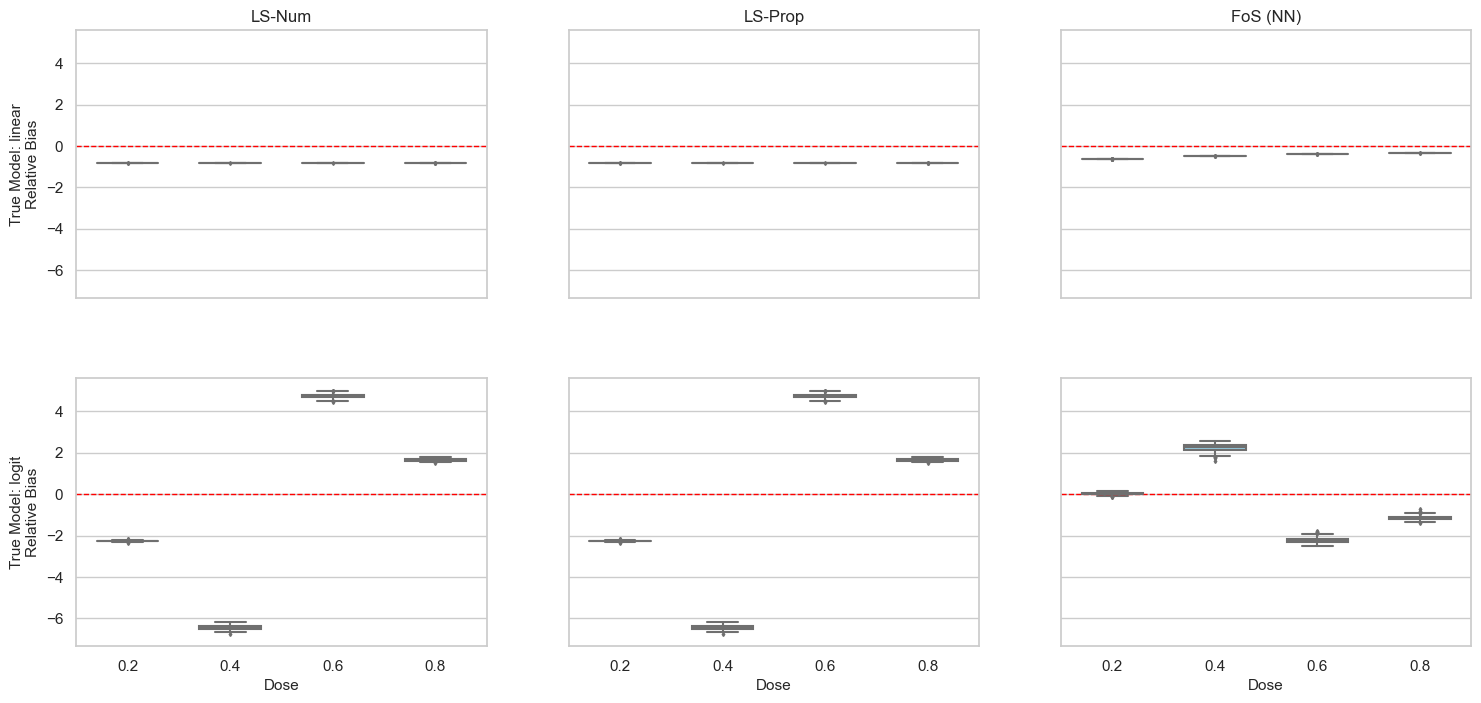

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 读取 simulation 结果 ===
df = pd.read_csv("doseS01layer3act/simulation_results_all_models.csv")

# === 只保留目标 estimator ===
selected_estimators = ['LS-Num', 'LS-Prop', 'FoS (NN)']
df_plot = df[df['estimator'].isin(selected_estimators)]

# === 设置 Seaborn 风格为浅蓝色配色，与之前风格一致 ===
sns.set(style="whitegrid", palette="pastel", font_scale=1.0)

# === 设置子图结构（2 行 true model × 4 列 estimator） ===
true_models = ['linear', 'logit']
estimators_order = ['LS-Num', 'LS-Prop', 'FoS (NN)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# === 绘制每个小图 ===
for i, model in enumerate(true_models):
    for j, est in enumerate(estimators_order):
        ax = axes[i, j]
        data = df_plot[(df_plot['true_model'] == model) & (df_plot['estimator'] == est)]
        sns.boxplot(x='dose', y='rel_bias', data=data, ax=ax, color="skyblue", width=0.6, fliersize=2)

        ax.axhline(0, color='red', linestyle='--', linewidth=1)

        if i == 0:
            ax.set_title(est, fontsize=12)
        if j == 0:
            ax.set_ylabel(f"True Model: {model}\nRelative Bias", fontsize=11)
        else:
            ax.set_ylabel("")
        if i == 1:
            ax.set_xlabel("Dose", fontsize=11)
        else:
            ax.set_xlabel("")

# === 保存图像 ===
os.makedirs("dose1", exist_ok=True)
plt.savefig("dose1/boxplot_rel_bias_by_dose_styled_flipped.png", dpi=300)
plt.show()

Dose start 0.2, NN 1 layer 3 act

In [16]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'doseS021layer3act/'
save_path_graphs = 'doseS021layer3act/'

In [17]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import nci_linear_setup as ncls
import nci_polynomial_setup as ncps
import os
import torch
import torch.nn as nn

# === Parameters ===
n = 4000
tau, Lambda, alpha = 2.0, -2.0, 1.0
k_list = [10]
sigma2 = 0.1
T = 200 
d = 5
beta_vec = np.array([1, 2, 2, 1, 3])
dose_list = [0.4, 0.6, 0.8]

# === Functions ===
def generate_covariates(n, d):
    X = np.random.randn(n, d)
    return (X - X.mean(axis=0)) / X.std(axis=0)

def compute_kernel(X, alpha):
    dist2 = squareform(pdist(X)) ** 2
    K = np.exp(-alpha * dist2)
    np.fill_diagonal(K, 0)
    return K

def compute_multi_kernel(X, alpha):
    d = X.shape[1]
    K_list = []
    for k in range(d):
        x_k = X[:, k][:, np.newaxis]
        dist2 = squareform(pdist(x_k)) ** 2
        K = np.exp(-alpha * dist2)
        np.fill_diagonal(K, 0)
        K_list.append(K)
    return np.array(K_list)  # shape (d, n, n)

def construct_adjacency_from_kernel(K, k):
    n = K.shape[0]
    A = np.zeros((n, n))
    for i in range(n):
        neighbors = np.argsort(-K[i, :])[:k]
        A[i, neighbors] = 1
    np.fill_diagonal(A, 1)
    return scipy.sparse.csr_matrix(A)


def compute_vector_exposure(K_list, z):
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)
    return E  # shape (n, d)

def generate_outcomes(z0, z1, A, K_list, true_model, D_fixed):
    E0 = compute_vector_exposure(K_list, z0)
    E1 = compute_vector_exposure(K_list, z1)
    eps = np.random.normal(0, np.sqrt(sigma2), size=n)

    if true_model == 'linear':
        f = lambda e: np.dot(beta_vec, e)
        f_vec0 = np.array([f(e) for e in E0])
        f_vec1 = np.array([f(e) for e in E1])
        y0 = tau * z0 + f_vec0 + eps
        y1 = tau * z1 + f_vec1
        true_ate = tau * (D_fixed-0.2) + np.mean(f_vec1) - np.mean(f_vec0)

    elif true_model == 'logit':
        f = lambda e: Lambda / (1 + np.exp(-np.dot(beta_vec, e)))
        f_vec0 = np.array([f(e) for e in E0])
        f_vec1 = np.array([f(e) for e in E1])
        y0 = tau * z0 + f_vec0 + eps
        y1 = tau * z1 + f_vec1
        true_ate = tau * (D_fixed-0.2) + np.mean(f_vec1) - np.mean(f_vec0)

    else:
        raise ValueError("Unknown true_model")

    return y0, y1, E0, E1, true_ate



def fos_model_estimator_linear(y0, z0, y1, z1, K_list):
    E1 = compute_vector_exposure(K_list, z1)
    E0 = compute_vector_exposure(K_list, z0)
    d = E1.shape[1]
    y = np.concatenate([y1, y0])
    z = np.concatenate([z1, z0])
    E = np.vstack([E1, E0])

    def loss(params):
        tau = params[0]
        beta = params[1:]
        f_E = E @ beta
        return np.sum((y - tau * z - f_E) ** 2)

    x0 = np.concatenate(([1.0], np.ones(d)))
    res = minimize(loss, x0=x0, method='L-BFGS-B')
    tau_hat, *beta_hat = res.x

    D1 = np.mean(z1)
    D0 = np.mean(z0)
    f_E1 = E1 @ np.array(beta_hat)
    f_E0 = E0 @ np.array(beta_hat)

    ate_diff = tau_hat * (D1 - D0) + np.mean(f_E1) - np.mean(f_E0)
    return ate_diff




def fos_nn_estimator(y0, z0, y1, z1, K_list, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    torch.manual_seed(seed)

    # === 构造 exposure E1 和 E0 ===
    E1 = compute_vector_exposure(K_list, z1)
    E0 = compute_vector_exposure(K_list, z0)

    # === 拼接所有样本 ===
    y = np.concatenate([y1, y0])
    z = np.concatenate([z1, z0])
    E = np.vstack([E1, E0])

    # === 转换为 torch tensor ===
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32)

    # === 融合激活结构 ===
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super(FoSNet, self).__init__()
            self.linear1 = nn.Linear(input_dim, h1)   # Linear node
            self.linear2 = nn.Linear(input_dim, h2)   # Tanh node
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)   # PReLU node
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            o1 = self.linear1(E)
            o2 = self.act2(self.linear2(E))
            o3 = self.act3(self.linear3(E))
            x = torch.cat([o1, o2, o3], dim=1)
            return self.output(x).squeeze(-1)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super(FoSFullModel, self).__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    # === Fit ===
    model = FoSFullModel(input_dim=E.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    # === Estimate ATE ===
    with torch.no_grad():
        E1_torch = torch.tensor(E1, dtype=torch.float32)
        E0_torch = torch.tensor(E0, dtype=torch.float32)
        D1 = z1.mean()
        D0 = z0.mean()
        f_E1 = model.f_net(E1_torch).mean().item()
        f_E0 = model.f_net(E0_torch).mean().item()
        tau_hat = model.tau.item()
        ate_diff = tau_hat * (D1 - D0) + f_E1 - f_E0

    return ate_diff


   


def est_ols_gen_dose(y1, z1, A, y0, z0, A_baseline=None):
    if A_baseline is None:
        A_baseline = A

    n = len(y1)

    # 构造 design matrix for target dose
    X1 = np.ones((n, 3))
    X1[:, 1] = z1
    X1[:, 2] = (A.dot(z1) - z1) / (np.array(A.sum(axis=1)).flatten() - 1 + 1e-10)

    v1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
    D1 = np.mean(z1)
    exposure1 = np.mean(X1[:, 2])

    # 构造 design matrix for baseline dose
    X0 = np.ones((n, 3))
    X0[:, 1] = z0
    X0[:, 2] = (A_baseline.dot(z0) - z0) / (np.array(A_baseline.sum(axis=1)).flatten() - 1 + 1e-10)

    v0 = np.linalg.lstsq(X0, y0, rcond=None)[0]
    D0 = np.mean(z0)
    exposure0 = np.mean(X0[:, 2])

    return (v1[1] * D1 + v1[2] * exposure1) - (v0[1] * D0 + v0[2] * exposure0)



def est_ols_treated_dose(y1, z1, A, y0, z0, A_baseline=None):
    if A_baseline is None:
        A_baseline = A

    n = len(y1)

    # 构造 design matrix for target dose
    X1 = np.ones((n, 3))
    X1[:, 1] = z1
    X1[:, 2] = A.dot(z1) - z1

    v1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
    D1 = np.mean(z1)
    exposure1 = np.mean(X1[:, 2])

    # 构造 design matrix for baseline dose
    X0 = np.ones((n, 3))
    X0[:, 1] = z0
    X0[:, 2] = A_baseline.dot(z0) - z0

    v0 = np.linalg.lstsq(X0, y0, rcond=None)[0]
    D0 = np.mean(z0)
    exposure0 = np.mean(X0[:, 2])

    return (v1[1] * D1 + v1[2] * exposure1) - (v0[1] * D0 + v0[2] * exposure0)





def generate_fixed_treatment(n, D, seed=None):
    """
    Generate a binary treatment vector with fixed treatment proportion D.
    """
    if seed is not None:
        np.random.seed(seed)
    num_treated = int(D * n)
    z = np.zeros(n)
    z[:num_treated] = 1
    np.random.shuffle(z)
    return z




# === Simulation ===
os.makedirs(save_path, exist_ok=True)
all_records = []

for true_model in ['linear', 'logit']:
    print(f"Running true_model = {true_model}")
    for D_fixed in dose_list:
        for t in range(T):
            X = generate_covariates(n,d)
            K = compute_multi_kernel(X, alpha)
            K2 = compute_kernel(X, alpha)
            z1 = generate_fixed_treatment(n, D_fixed)
            z0 = generate_fixed_treatment(n, 0.2)

            for k in k_list:
                A = construct_adjacency_from_kernel(K2, k)
                y0, y1, E0, E1, true_ate = generate_outcomes(z0, z1, A, K, true_model, D_fixed)

                # LS-Num
                est = est_ols_gen_dose(y1, z1, A, y0, z0)  # 若你采用新版本函数
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Num', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # LS-Prop
                est = est_ols_treated_dose(y1, z1, A, y0, z0)
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Prop', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # FoS (linear)
                est = fos_model_estimator_linear(y0, z0, y1, z1, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (linear)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed  # 添加 dose
                })

                # FoS (NN)
                est = fos_nn_estimator(y0, z0, y1, z1, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (NN)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed
                })


# === Save results ===
df = pd.DataFrame(all_records)
df.to_csv(os.path.join(save_path, "simulation_results_all_models.csv"), index=False)

Running true_model = linear
Running true_model = logit


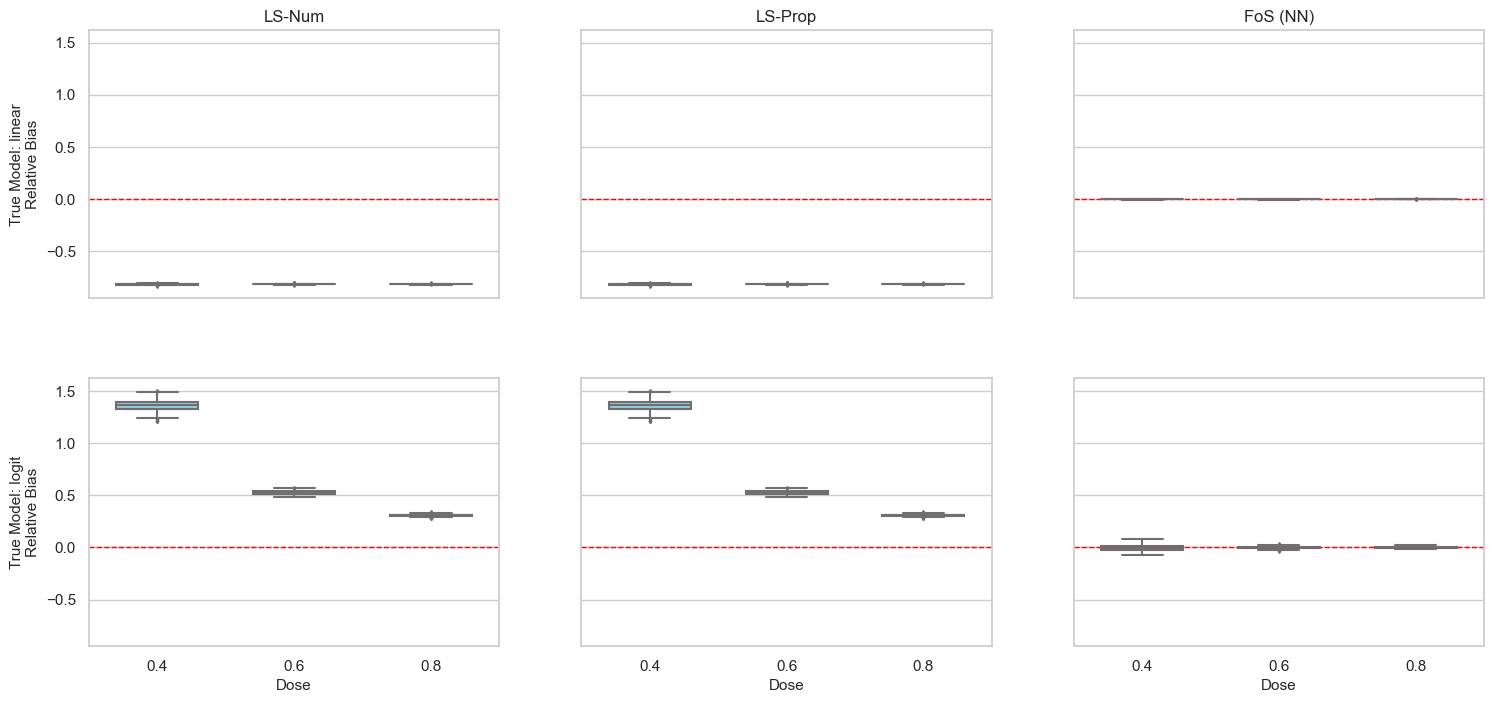

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 读取 simulation 结果 ===
df = pd.read_csv("doseS021layer3act/simulation_results_all_models.csv")

# === 只保留目标 estimator ===
selected_estimators = ['LS-Num', 'LS-Prop', 'FoS (NN)']
df_plot = df[df['estimator'].isin(selected_estimators)]

# === 设置 Seaborn 风格为浅蓝色配色，与之前风格一致 ===
sns.set(style="whitegrid", palette="pastel", font_scale=1.0)

# === 设置子图结构（2 行 true model × 4 列 estimator） ===
true_models = ['linear', 'logit']
estimators_order = ['LS-Num', 'LS-Prop', 'FoS (NN)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# === 绘制每个小图 ===
for i, model in enumerate(true_models):
    for j, est in enumerate(estimators_order):
        ax = axes[i, j]
        data = df_plot[(df_plot['true_model'] == model) & (df_plot['estimator'] == est)]
        sns.boxplot(x='dose', y='rel_bias', data=data, ax=ax, color="skyblue", width=0.6, fliersize=2)

        ax.axhline(0, color='red', linestyle='--', linewidth=1)

        if i == 0:
            ax.set_title(est, fontsize=12)
        if j == 0:
            ax.set_ylabel(f"True Model: {model}\nRelative Bias", fontsize=11)
        else:
            ax.set_ylabel("")
        if i == 1:
            ax.set_xlabel("Dose", fontsize=11)
        else:
            ax.set_xlabel("")

# === 保存图像 ===
os.makedirs("dose1", exist_ok=True)
plt.savefig("dose1/boxplot_rel_bias_by_dose_styled_flipped.png", dpi=300)
plt.show()

Dose start 0.4, NN 1 layer 3 act

In [19]:
path_to_module = os.getcwd()  # 当前工作目录

#save_path = 'outputFiles/new/'
save_path = 'doseS041layer3act/'
save_path_graphs = 'doseS041layer3act/'

In [20]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import nci_linear_setup as ncls
import nci_polynomial_setup as ncps
import os
import torch
import torch.nn as nn

# === Parameters ===
n = 4000
tau, Lambda, alpha = 2.0, -2.0, 1.0
k_list = [10]
sigma2 = 0.1
T = 200 
d = 5
beta_vec = np.array([1, 2, 2, 1, 3])
dose_list = [0.6, 0.8]

# === Functions ===
def generate_covariates(n, d):
    X = np.random.randn(n, d)
    return (X - X.mean(axis=0)) / X.std(axis=0)

def compute_kernel(X, alpha):
    dist2 = squareform(pdist(X)) ** 2
    K = np.exp(-alpha * dist2)
    np.fill_diagonal(K, 0)
    return K

def compute_multi_kernel(X, alpha):
    d = X.shape[1]
    K_list = []
    for k in range(d):
        x_k = X[:, k][:, np.newaxis]
        dist2 = squareform(pdist(x_k)) ** 2
        K = np.exp(-alpha * dist2)
        np.fill_diagonal(K, 0)
        K_list.append(K)
    return np.array(K_list)  # shape (d, n, n)

def construct_adjacency_from_kernel(K, k):
    n = K.shape[0]
    A = np.zeros((n, n))
    for i in range(n):
        neighbors = np.argsort(-K[i, :])[:k]
        A[i, neighbors] = 1
    np.fill_diagonal(A, 1)
    return scipy.sparse.csr_matrix(A)


def compute_vector_exposure(K_list, z):
    d, n, _ = K_list.shape
    E = np.zeros((n, d))
    for k in range(d):
        K = K_list[k]
        E[:, k] = K @ z / np.maximum(K.sum(axis=1), 1)
    return E  # shape (n, d)

def generate_outcomes(z0, z1, A, K_list, true_model, D_fixed):
    E0 = compute_vector_exposure(K_list, z0)
    E1 = compute_vector_exposure(K_list, z1)
    eps = np.random.normal(0, np.sqrt(sigma2), size=n)

    if true_model == 'linear':
        f = lambda e: np.dot(beta_vec, e)
        f_vec0 = np.array([f(e) for e in E0])
        f_vec1 = np.array([f(e) for e in E1])
        y0 = tau * z0 + f_vec0 + eps
        y1 = tau * z1 + f_vec1
        true_ate = tau * (D_fixed-0.4) + np.mean(f_vec1) - np.mean(f_vec0)

    elif true_model == 'logit':
        f = lambda e: Lambda / (1 + np.exp(-np.dot(beta_vec, e)))
        f_vec0 = np.array([f(e) for e in E0])
        f_vec1 = np.array([f(e) for e in E1])
        y0 = tau * z0 + f_vec0 + eps
        y1 = tau * z1 + f_vec1
        true_ate = tau * (D_fixed-0.4) + np.mean(f_vec1) - np.mean(f_vec0)

    else:
        raise ValueError("Unknown true_model")

    return y0, y1, E0, E1, true_ate



def fos_model_estimator_linear(y0, z0, y1, z1, K_list):
    E1 = compute_vector_exposure(K_list, z1)
    E0 = compute_vector_exposure(K_list, z0)
    d = E1.shape[1]
    y = np.concatenate([y1, y0])
    z = np.concatenate([z1, z0])
    E = np.vstack([E1, E0])

    def loss(params):
        tau = params[0]
        beta = params[1:]
        f_E = E @ beta
        return np.sum((y - tau * z - f_E) ** 2)

    x0 = np.concatenate(([1.0], np.ones(d)))
    res = minimize(loss, x0=x0, method='L-BFGS-B')
    tau_hat, *beta_hat = res.x

    D1 = np.mean(z1)
    D0 = np.mean(z0)
    f_E1 = E1 @ np.array(beta_hat)
    f_E0 = E0 @ np.array(beta_hat)

    ate_diff = tau_hat * (D1 - D0) + np.mean(f_E1) - np.mean(f_E0)
    return ate_diff




def fos_nn_estimator(y0, z0, y1, z1, K_list, lr=1e-2, max_iter=1000, h1=4, h2=4, h3=4, seed=0):
    torch.manual_seed(seed)

    # === 构造 exposure E1 和 E0 ===
    E1 = compute_vector_exposure(K_list, z1)
    E0 = compute_vector_exposure(K_list, z0)

    # === 拼接所有样本 ===
    y = np.concatenate([y1, y0])
    z = np.concatenate([z1, z0])
    E = np.vstack([E1, E0])

    # === 转换为 torch tensor ===
    y = torch.tensor(y, dtype=torch.float32)
    z = torch.tensor(z, dtype=torch.float32)
    E = torch.tensor(E, dtype=torch.float32)

    # === 新的一层网络结构（融合激活）===
    class FoSNet(nn.Module):
        def __init__(self, input_dim, h1, h2, h3):
            super().__init__()
            self.linear1 = nn.Linear(input_dim, h1)   # Linear unit
            self.linear2 = nn.Linear(input_dim, h2)   # Tanh unit
            self.act2 = nn.Tanh()
            self.linear3 = nn.Linear(input_dim, h3)   # PReLU unit
            self.act3 = nn.PReLU()
            self.output = nn.Linear(h1 + h2 + h3, 1)

        def forward(self, E):
            o1 = self.linear1(E)
            o2 = self.act2(self.linear2(E))
            o3 = self.act3(self.linear3(E))
            x = torch.cat([o1, o2, o3], dim=1)
            return self.output(x).squeeze(-1)

    class FoSFullModel(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.tau = nn.Parameter(torch.tensor(0.0))
            self.f_net = FoSNet(input_dim, h1, h2, h3)

        def forward(self, z, E):
            return self.tau * z + self.f_net(E)

    model = FoSFullModel(input_dim=E.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for _ in range(max_iter):
        optimizer.zero_grad()
        y_pred = model(z, E)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        E1_torch = torch.tensor(E1, dtype=torch.float32)
        E0_torch = torch.tensor(E0, dtype=torch.float32)
        D1 = z1.mean()
        D0 = z0.mean()
        f_E1 = model.f_net(E1_torch).mean().item()
        f_E0 = model.f_net(E0_torch).mean().item()
        tau_hat = model.tau.item()
        ate_diff = tau_hat * (D1 - D0) + f_E1 - f_E0

    return ate_diff



def est_ols_gen_dose(y1, z1, A, y0, z0, A_baseline=None):
    if A_baseline is None:
        A_baseline = A

    n = len(y1)

    # 构造 design matrix for target dose
    X1 = np.ones((n, 3))
    X1[:, 1] = z1
    X1[:, 2] = (A.dot(z1) - z1) / (np.array(A.sum(axis=1)).flatten() - 1 + 1e-10)

    v1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
    D1 = np.mean(z1)
    exposure1 = np.mean(X1[:, 2])

    # 构造 design matrix for baseline dose
    X0 = np.ones((n, 3))
    X0[:, 1] = z0
    X0[:, 2] = (A_baseline.dot(z0) - z0) / (np.array(A_baseline.sum(axis=1)).flatten() - 1 + 1e-10)

    v0 = np.linalg.lstsq(X0, y0, rcond=None)[0]
    D0 = np.mean(z0)
    exposure0 = np.mean(X0[:, 2])

    return (v1[1] * D1 + v1[2] * exposure1) - (v0[1] * D0 + v0[2] * exposure0)



def est_ols_treated_dose(y1, z1, A, y0, z0, A_baseline=None):
    if A_baseline is None:
        A_baseline = A

    n = len(y1)

    # 构造 design matrix for target dose
    X1 = np.ones((n, 3))
    X1[:, 1] = z1
    X1[:, 2] = A.dot(z1) - z1

    v1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
    D1 = np.mean(z1)
    exposure1 = np.mean(X1[:, 2])

    # 构造 design matrix for baseline dose
    X0 = np.ones((n, 3))
    X0[:, 1] = z0
    X0[:, 2] = A_baseline.dot(z0) - z0

    v0 = np.linalg.lstsq(X0, y0, rcond=None)[0]
    D0 = np.mean(z0)
    exposure0 = np.mean(X0[:, 2])

    return (v1[1] * D1 + v1[2] * exposure1) - (v0[1] * D0 + v0[2] * exposure0)





def generate_fixed_treatment(n, D, seed=None):
    """
    Generate a binary treatment vector with fixed treatment proportion D.
    """
    if seed is not None:
        np.random.seed(seed)
    num_treated = int(D * n)
    z = np.zeros(n)
    z[:num_treated] = 1
    np.random.shuffle(z)
    return z




# === Simulation ===
os.makedirs(save_path, exist_ok=True)
all_records = []

for true_model in ['linear', 'logit']:
    print(f"Running true_model = {true_model}")
    for D_fixed in dose_list:
        for t in range(T):
            X = generate_covariates(n,d)
            K = compute_multi_kernel(X, alpha)
            K2 = compute_kernel(X, alpha)
            z1 = generate_fixed_treatment(n, D_fixed)
            z0 = generate_fixed_treatment(n, 0.4)

            for k in k_list:
                A = construct_adjacency_from_kernel(K2, k)
                y0, y1, E0, E1, true_ate = generate_outcomes(z0, z1, A, K, true_model, D_fixed)

                # LS-Num
                est = est_ols_gen_dose(y1, z1, A, y0, z0)  
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Num', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # LS-Prop
                est = est_ols_treated_dose(y1, z1, A, y0, z0)
                all_records.append({'rep': t, 'k': k, 'true_model': true_model,
                                    'estimator': 'LS-Prop', 'est': est, 'true_ate': true_ate,
                                    'rel_bias': (est - true_ate) / true_ate,
                                    'dose': D_fixed})

                # FoS (linear)
                est = fos_model_estimator_linear(y0, z0, y1, z1, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (linear)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed  # 添加 dose
                })

                # FoS (NN)
                est = fos_nn_estimator(y0, z0, y1, z1, K)
                all_records.append({
                    'rep': t, 'k': k, 'true_model': true_model,
                    'estimator': 'FoS (NN)', 'est': est,
                    'true_ate': true_ate, 'rel_bias': (est - true_ate) / true_ate,
                    'dose': D_fixed
                })


# === Save results ===
df = pd.DataFrame(all_records)
df.to_csv(os.path.join(save_path, "simulation_results_all_models.csv"), index=False)

Running true_model = linear
Running true_model = logit


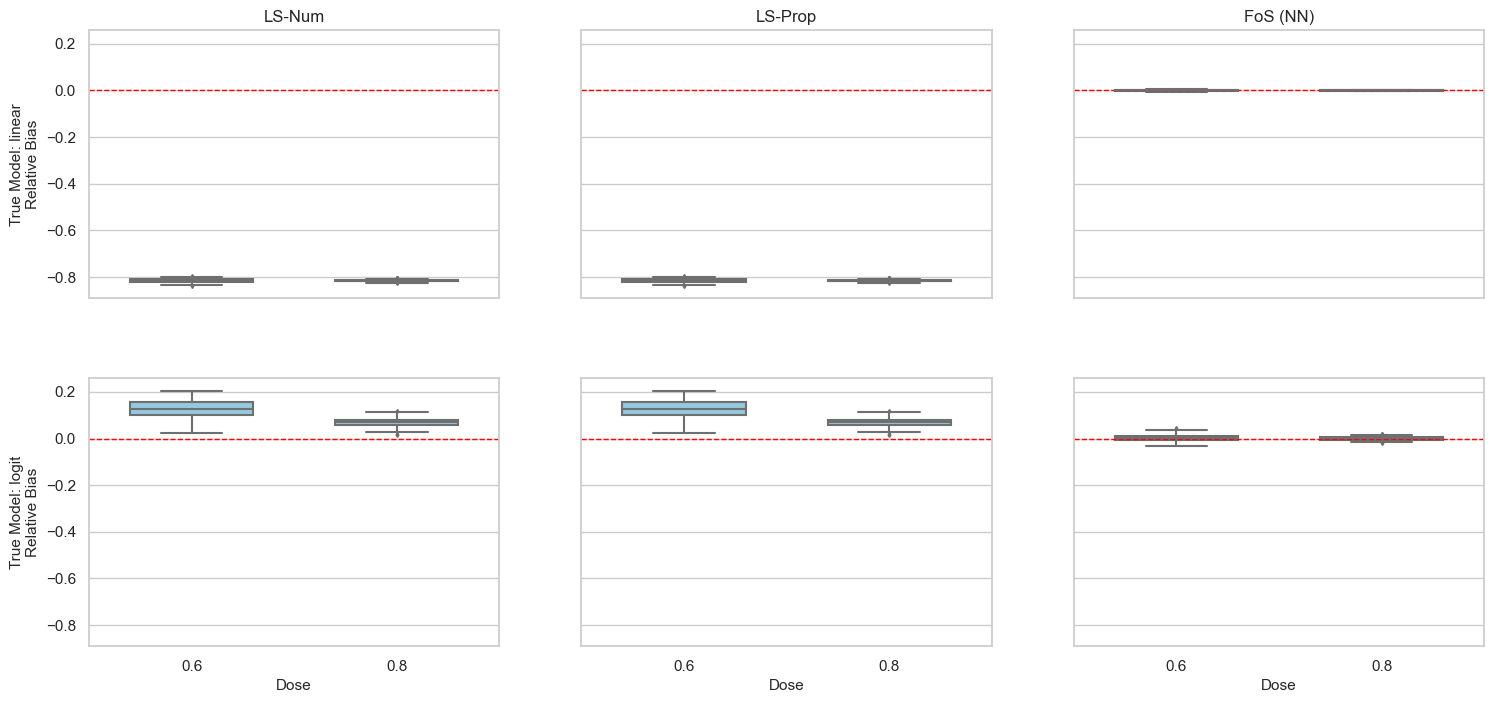

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 读取 simulation 结果 ===
df = pd.read_csv("doseS041layer3act/simulation_results_all_models.csv")

# === 只保留目标 estimator ===
selected_estimators = ['LS-Num', 'LS-Prop', 'FoS (NN)']
df_plot = df[df['estimator'].isin(selected_estimators)]

# === 设置 Seaborn 风格为浅蓝色配色，与之前风格一致 ===
sns.set(style="whitegrid", palette="pastel", font_scale=1.0)

# === 设置子图结构（2 行 true model × 4 列 estimator） ===
true_models = ['linear', 'logit']
estimators_order = ['LS-Num', 'LS-Prop', 'FoS (NN)']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# === 绘制每个小图 ===
for i, model in enumerate(true_models):
    for j, est in enumerate(estimators_order):
        ax = axes[i, j]
        data = df_plot[(df_plot['true_model'] == model) & (df_plot['estimator'] == est)]
        sns.boxplot(x='dose', y='rel_bias', data=data, ax=ax, color="skyblue", width=0.6, fliersize=2)

        ax.axhline(0, color='red', linestyle='--', linewidth=1)

        if i == 0:
            ax.set_title(est, fontsize=12)
        if j == 0:
            ax.set_ylabel(f"True Model: {model}\nRelative Bias", fontsize=11)
        else:
            ax.set_ylabel("")
        if i == 1:
            ax.set_xlabel("Dose", fontsize=11)
        else:
            ax.set_xlabel("")

# === 保存图像 ===
os.makedirs("dose1", exist_ok=True)
plt.savefig("dose1/boxplot_rel_bias_by_dose_styled_flipped.png", dpi=300)
plt.show()